# Working with Regions

Regions are rectangular areas on a page that define boundaries for operations like text extraction, element finding, or visualization. They're one of Natural PDF's most powerful features for working with specific parts of a document.

## Setup

Let's set up a PDF to experiment with regions.

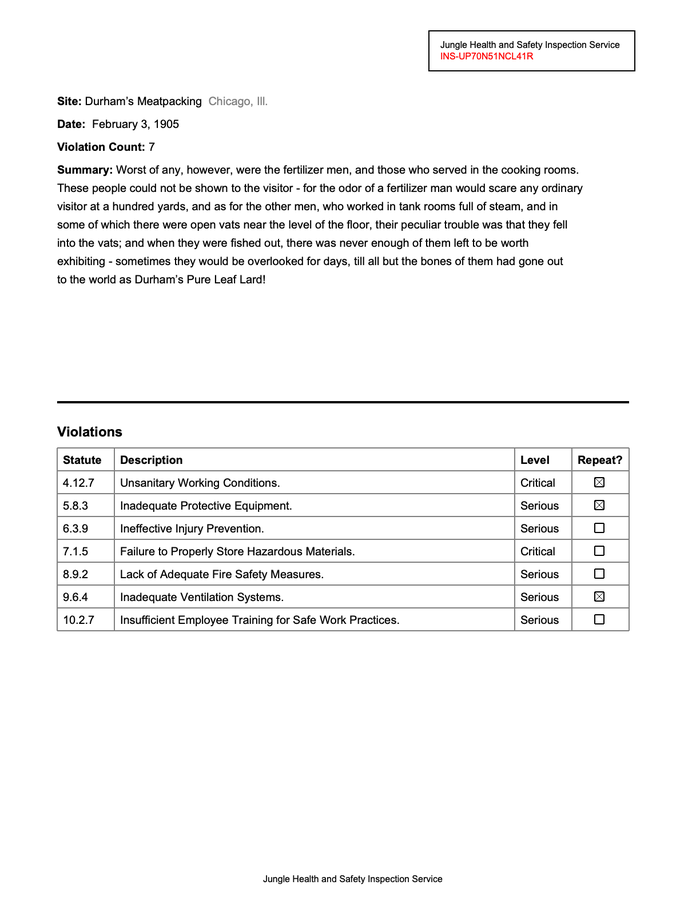

In [1]:
from natural_pdf import PDF

# Load the PDF
pdf = PDF("https://github.com/jsoma/natural-pdf/raw/refs/heads/main/pdfs/01-practice.pdf")

# Get the first page
page = pdf.pages[0]

# Display the page
page.show(width=700)

## Creating Regions

There are several ways to create regions in Natural PDF.

### Using `create_region()` with Coordinates

This is the most direct method - provide the coordinates directly.

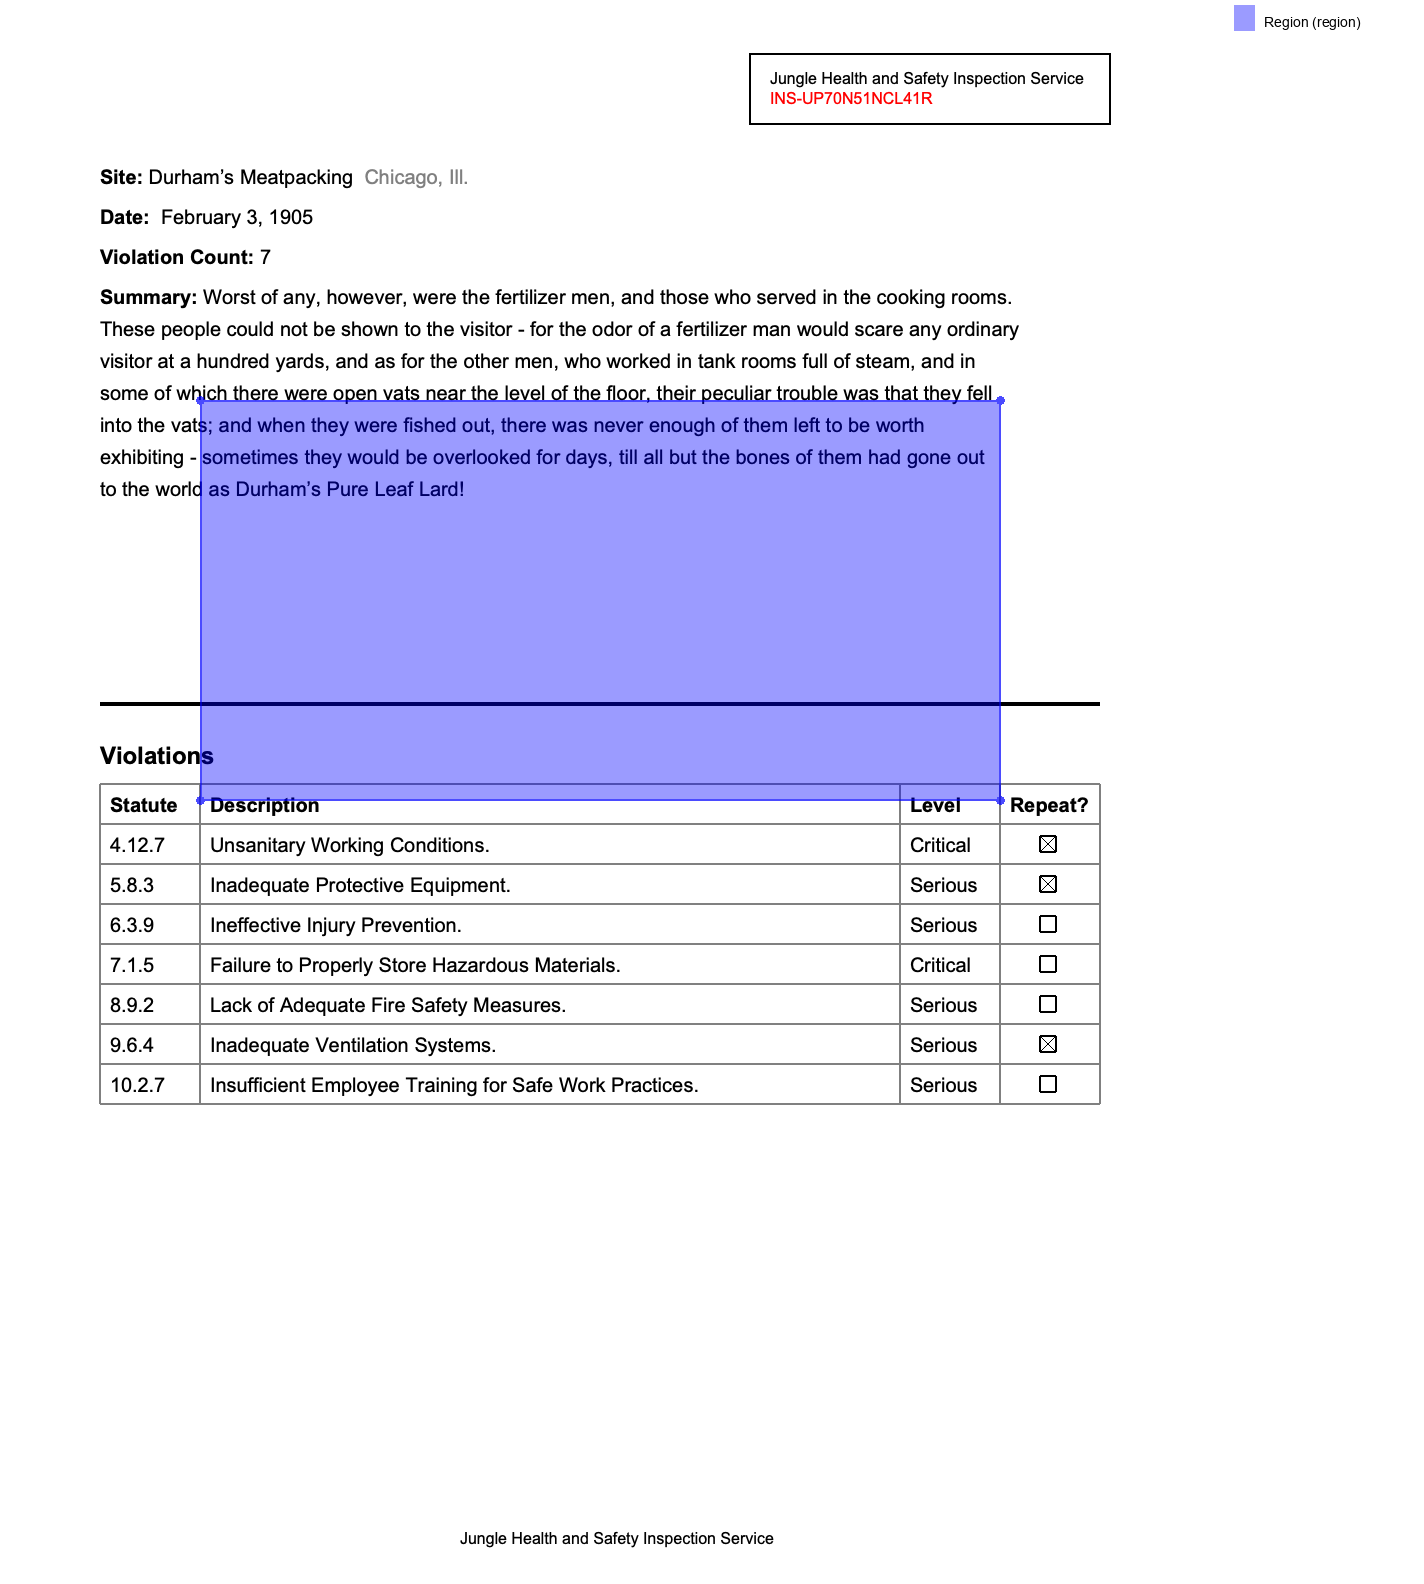

In [2]:
# Create a region by specifying (x0, top, x1, bottom) coordinates
# Let's create a region in the middle of the page
mid_region = page.create_region(
    x0=100,         # Left edge
    top=200,        # Top edge
    x1=500,         # Right edge
    bottom=400      # Bottom edge
)

# Highlight the region to see it
mid_region.highlight(color="blue").show()

### Using Element Methods: `above()`, `below()`, `left()`, `right()`

You can create regions relative to existing elements.

In [3]:
# Find a heading-like element
heading = page.find('text[size>=12]:bold')

# Create a region below this heading element
if heading:
    region_below = heading.below()
    
    # Highlight the heading and the region below it
    heading.highlight(color="red")
    region_below.highlight(color="blue")
    page.show()

In [4]:
# Create a region with height limit
if heading:
    # Only include 100px below the heading
    small_region_below = heading.below(height=100)
    
    page.clear_highlights()
    heading.highlight(color="red")
    small_region_below.highlight(color="green")
    page.show()

In [5]:
# Find a line or other element to create a region above
line = page.find('line')
if line:
    # Create a region above the line
    region_above = line.above()
    
    page.clear_highlights()
    line.highlight(color="black")
    region_above.highlight(color="purple")
    page.show()

### Creating a Region Between Elements with `until()`

In [6]:
# Find two elements to use as boundaries
first_heading = page.find('text[size>=11]:bold')
next_heading = first_heading.next('text[size>=11]:bold') if first_heading else None

if first_heading and next_heading:
    # Create a region from the first heading until the next heading
    section = first_heading.below(until=next_heading, include_endpoint=False)
    
    # Highlight both elements and the region between them
    page.clear_highlights()
    first_heading.highlight(color="red")
    next_heading.highlight(color="red")
    section.highlight(color="yellow")
    page.show()

## Using Regions

Once you have a region, here's what you can do with it.

### Extract Text from a Region

In [7]:
# Find a region to work with (e.g., from a title to the next bold text)
title = page.find('text:contains("Site")')  # Adjust if needed
if title:
    # Create a region from title down to the next bold text
    content_region = title.below(until='line:horizontal', include_endpoint=False)
    
    # Extract text from just this region
    region_text = content_region.extract_text()
    
    # Show the region and the extracted text
    page.clear_highlights()
    content_region.highlight(color="green")
    page.show()
    
    # Displaying the text (first 300 chars if long)
    print(region_text[:300] + "..." if len(region_text) > 300 else region_text)

Date:  February 3, 1905 Violation Count:  7 Summary:  Worst of any, however, were the fertilizer men, and those who served in the cooking rooms. These people could not be shown to the visitor - for the odor of a fertilizer man would scare any ordinary  visitor at a hundred yards, and as for the othe...


### Find Elements Within a Region

You can use a region as a "filter" to only find elements within its boundaries.

In [8]:
# Create a region in an interesting part of the page
test_region = page.create_region(
    x0=page.width * 0.1, 
    top=page.height * 0.25, 
    x1=page.width * 0.9, 
    bottom=page.height * 0.75
)

# Find all text elements ONLY within this region
text_in_region = test_region.find_all('text')

# Display result
page.clear_highlights()
test_region.highlight(color="blue")
text_in_region.highlight(color="red")
page.show()

len(text_in_region)  # Number of text elements found in region

29

### Generate an Image of a Region

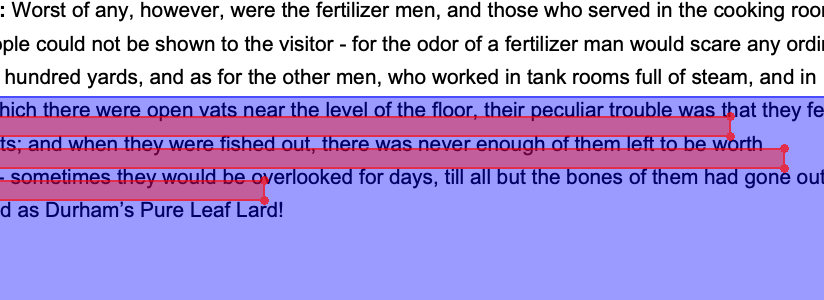

In [9]:
# Find a specific region to capture
# (Could be a table, figure, or any significant area)
region_for_image = page.create_region(
    x0=100, 
    top=150,
    x1=page.width - 100,
    bottom=300
)

# Generate an image of just this region
region_for_image.to_image(crop_only=True)  # Shows just the region

### Adjust and Expand Regions

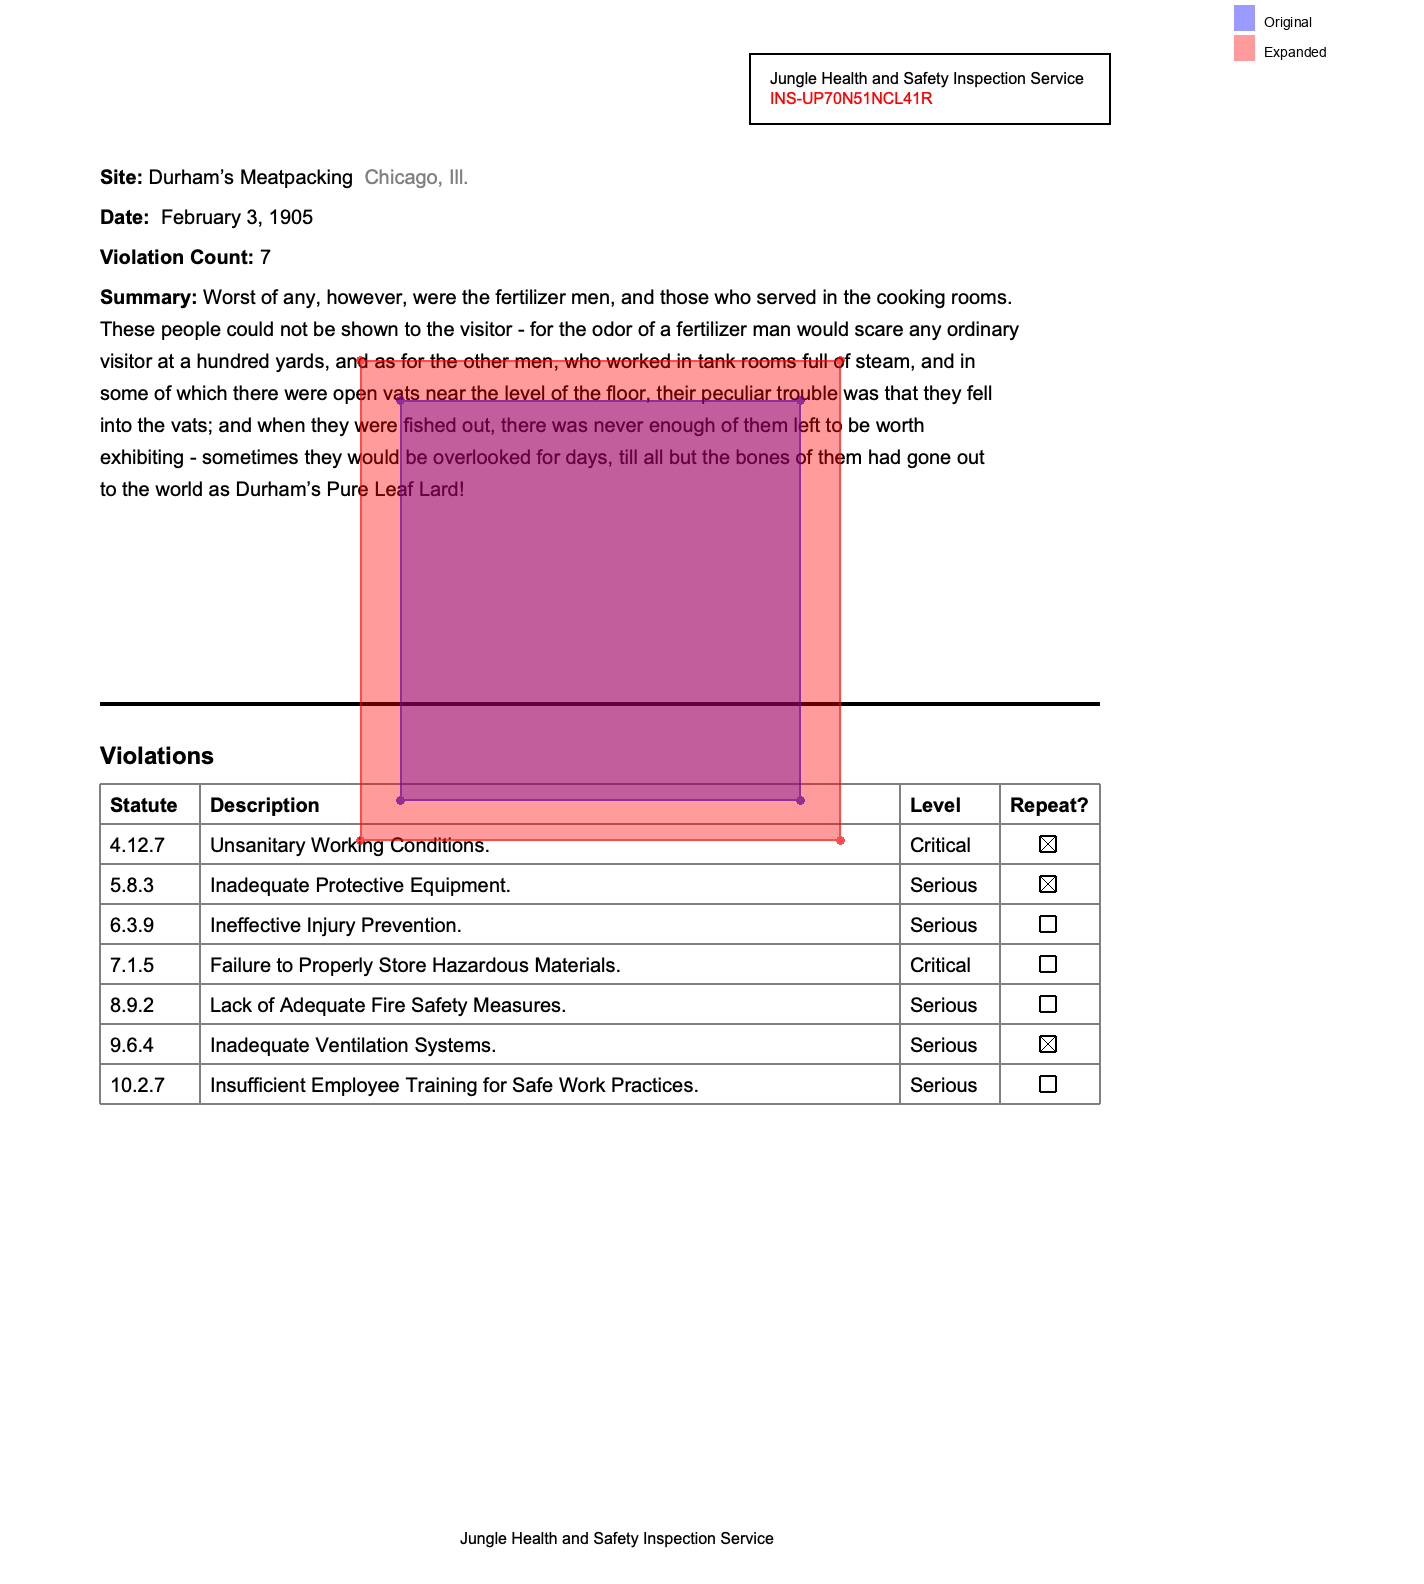

In [10]:
# Take an existing region and expand it
region_a = page.create_region(200, 200, 400, 400)

# Expand by a certain number of points in each direction
expanded = region_a.expand(left=20, right=20, top=20, bottom=20)

# Visualize original and expanded regions
page.clear_highlights()
region_a.highlight(color="blue", label="Original")
expanded.highlight(color="red", label="Expanded")
page.to_image()

## Using Exclusion Zones with Regions

Exclusion zones are regions that you want to ignore during operations like text extraction.

In [11]:
# Create a region for the whole page
full_page_region = page.create_region(0, 0, page.width, page.height)

# Extract text without exclusions as baseline
full_text = full_page_region.extract_text()
print(f"Full page text length: {len(full_text)} characters")

Full page text length: 1262 characters


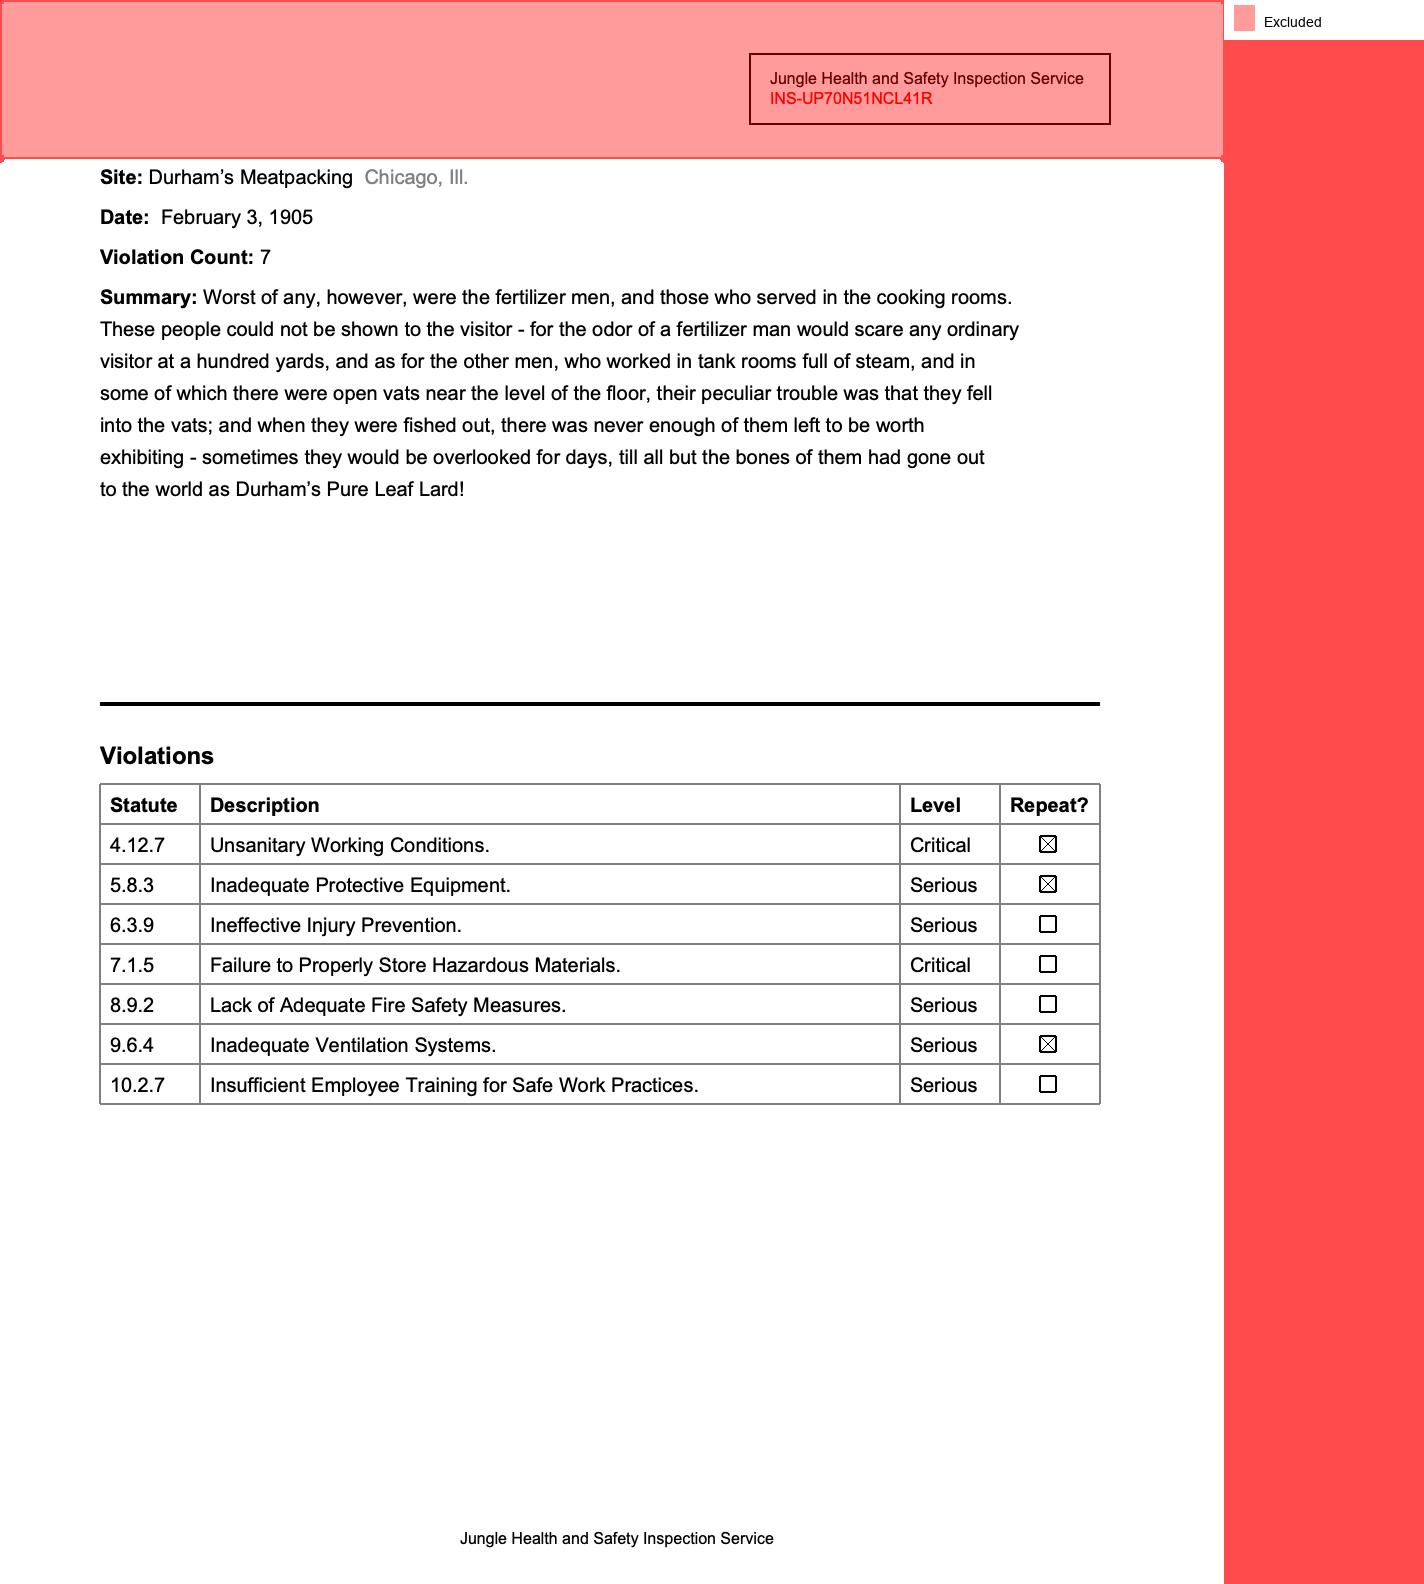

In [12]:
# Define an area we want to exclude (like a header)
# Let's exclude the top 10% of the page
header_zone = page.create_region(0, 0, page.width, page.height * 0.1)

# Add this as an exclusion for the page
page.add_exclusion(header_zone)

# Visualize the exclusion
page.clear_highlights()
header_zone.highlight(color="red", label="Excluded")
page.show()

In [13]:
# Now extract text again - the header should be excluded
text_with_exclusion = full_page_region.extract_text() # Uses apply_exclusions=True by default

# Compare text lengths
print(f"Original text: {len(full_text)} chars\nText with exclusion: {len(text_with_exclusion)} chars")
print(f"Difference: {len(full_text) - len(text_with_exclusion)} chars excluded")

Original text: 1262 chars
Text with exclusion: 1198 chars
Difference: 64 chars excluded


In [14]:
# When done with this page, clear exclusions
page.clear_exclusions()

<Page number=1 index=0>

## Document-Level Exclusions

PDF-level exclusions apply to all pages and use functions to adapt to each page.

In [15]:
# Define a PDF-level exclusion for headers
# This will exclude the top 30% of every page
pdf.add_exclusion(
    lambda p: p.create_region(0, 0, p.width, p.height * 0.3),
    label="Header zone"
)

# Define a PDF-level exclusion for footers
# This will exclude the bottom 20% of every page
pdf.add_exclusion(
    lambda p: p.create_region(0, p.height * 0.8, p.width, p.height),
    label="Footer zone"
)

# PDF-level exclusions are used whenever you extract text
# Let's try on the first three pages
for page in pdf.pages[:3]:
    text = page.extract_text()
    text_original = page.extract_text(use_exclusions=False)
    print(f"Page {page.number} – Before: {len(text_original)} After: {len(text)}")

Page 1 – Before: 1260 After: 456


In [16]:
# Clear PDF-level exclusions when done
pdf.clear_exclusions()
print("Cleared all PDF-level exclusions")

Cleared all PDF-level exclusions


## Working with Layout Analysis Regions

When you run layout analysis, the detected regions (tables, titles, etc.) are also Region objects.

In [17]:
# First, run layout analysis to detect regions
page.analyze_layout()  # Uses 'yolo' engine by default

# Find all detected regions
detected_regions = page.find_all('region')
print(f"Found {len(detected_regions)} layout regions")

image 1/1 /var/folders/25/h3prywj14qb0mlkl2s8bxq5m0000gn/T/tmpw8v45ahq/temp_layout_image.png: 1024x800 2 titles, 3 plain texts, 2 abandons, 1 table, 1574.9ms


Speed: 4.1ms preprocess, 1574.9ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 800)


Found 8 layout regions


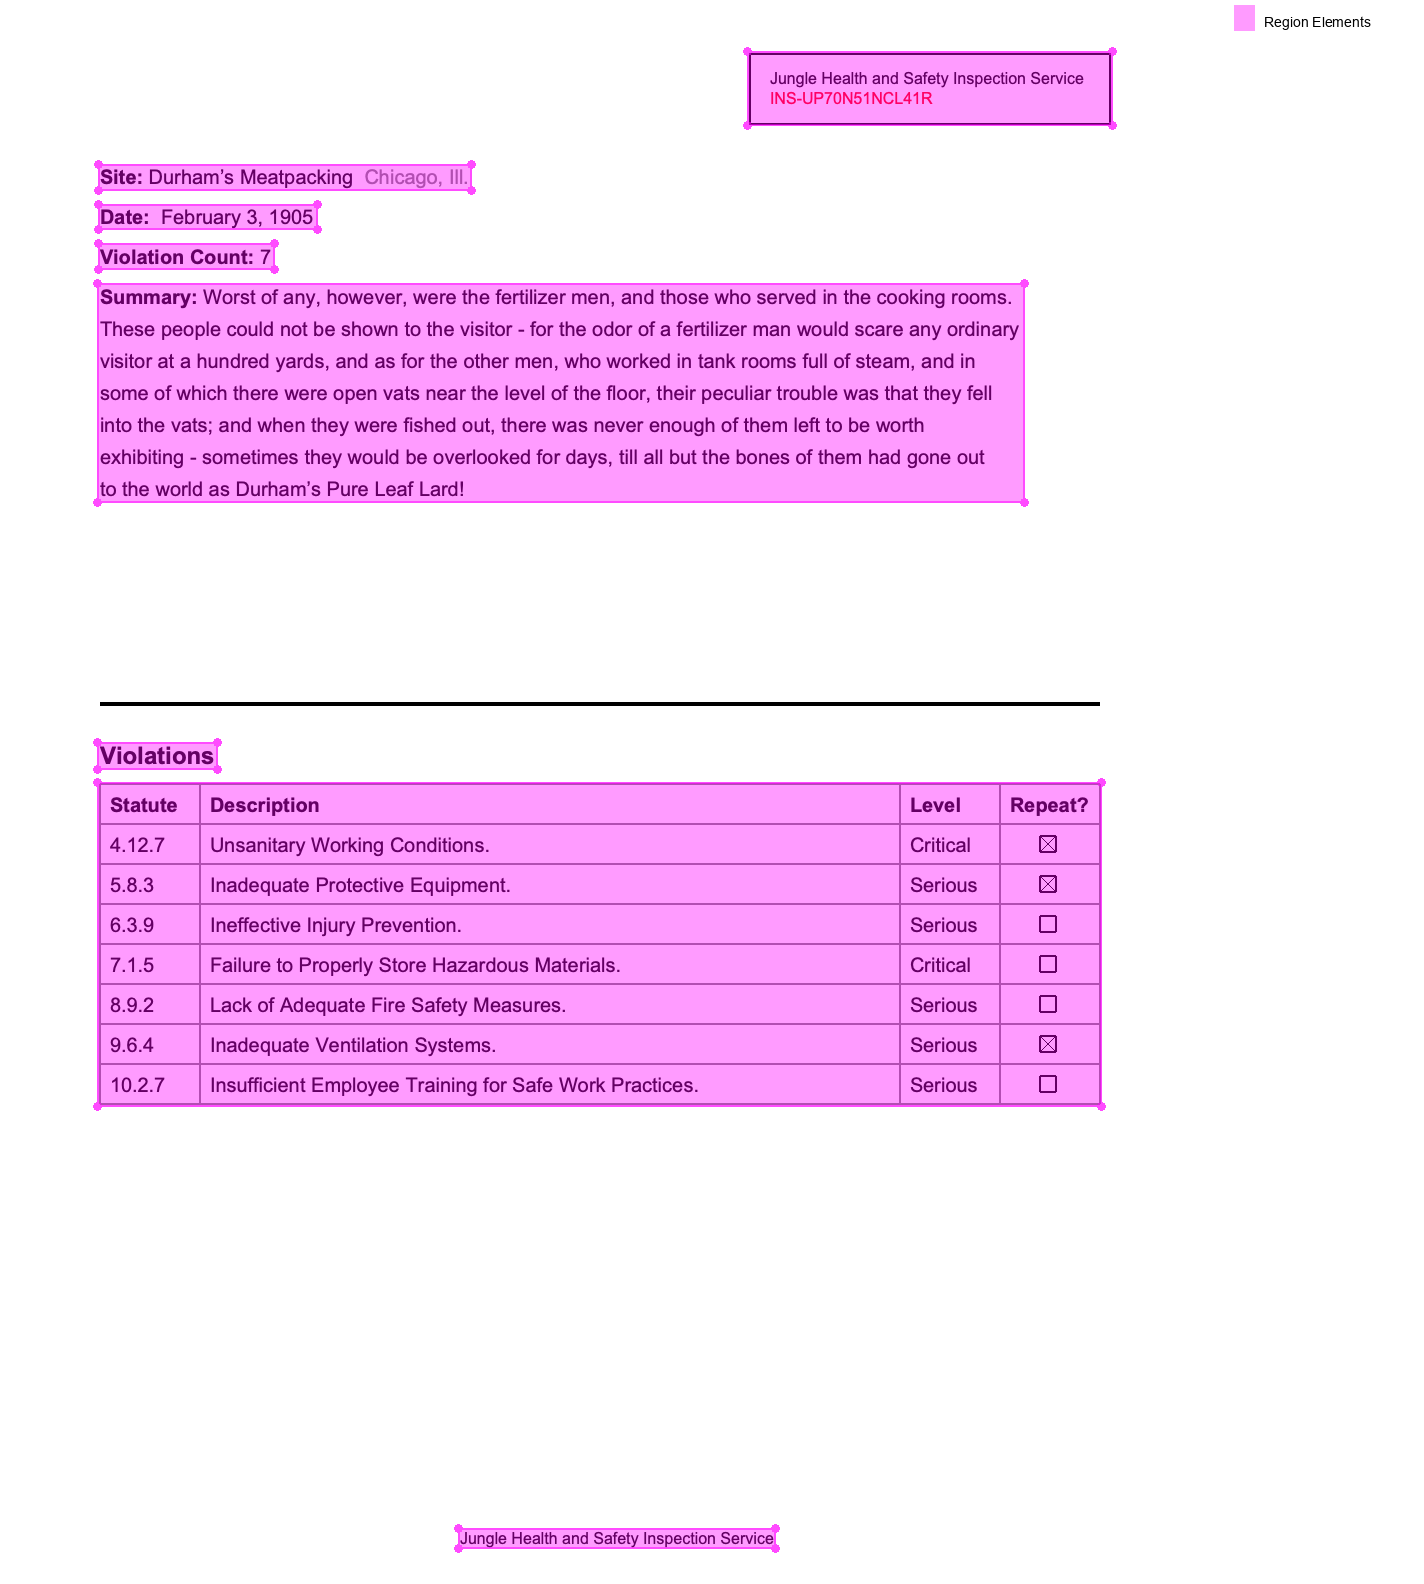

In [18]:
# Highlight all detected regions by type
detected_regions.highlight(group_by='region_type').show()

In [19]:
# Extract text from a specific region type (e.g., title)
title_regions = page.find_all('region[type=title]')
if title_regions:
    titles_text = title_regions.extract_text()
    print(f"Title text: {titles_text}")

Title text: Violation Count:  7 Violations


## Next Steps

Now that you understand regions, you can:

- [Extract tables](../tables/index.ipynb) from table regions
- [Ask questions](../document-qa/index.ipynb) about specific regions
- [Exclude content](../text-extraction/index.md#filtering-out-headers-and-footers) from extraction